# Lab5 - Training Deep Convolutional Neural Network
- นาย นันท์มนัส ตั้งประเสริฐ, 63070501040
- นาย สัณหณัฐ พรมจรรย์, 63070501069


Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use MNIST and Cat vs Dog dataset.

See http://yann.lecun.com/exdb/mnist <br>
See https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load _utils
# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['sparse_categorical_accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_sparse_categorical_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)

    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### 1. Load MNIST dataset

In [3]:
### Load dataset ###
(X_train,y_train), (X_test,y_test) = mnist.load_data()
####################

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
X_train.shape

(60000, 28, 28)

### 2. Preprocess data

In [5]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    data = data.astype('float32')/255.
    return data

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [6]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [7]:
BATCH_SIZE = 32

### 3. Build a convolutional neural network
Try to build a network that have a same or out perform our previous fully-connect model.

In [ ]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='elu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(10,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.save('baseline_model.h5')
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trainable params: 870634 (3.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4. Trainig CNN Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

Epoch 1/20
844/844 [==============================] - 245s 285ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9795
Epoch 2/20
844/844 [==============================] - 231s 274ms/step - loss: 0.0892 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0514 - val_sparse_categorical_accuracy: 0.9860
Epoch 3/20
844/844 [==============================] - 229s 271ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0492 - val_sparse_categorical_accuracy: 0.9875
Epoch 4/20
844/844 [==============================] - 230s 272ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.0430 - val_sparse_categorical_accuracy: 0.9888
Epoch 5/20
844/844 [==============================] - 243s 287ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.0455 - val_sparse_categorical_accuracy: 0.9900
Epoch 6/20
844/844 [==============================] - 230s 273ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last train accuracy: 0.9897962808609009
Last validation accuracy: 0.9918333292007446


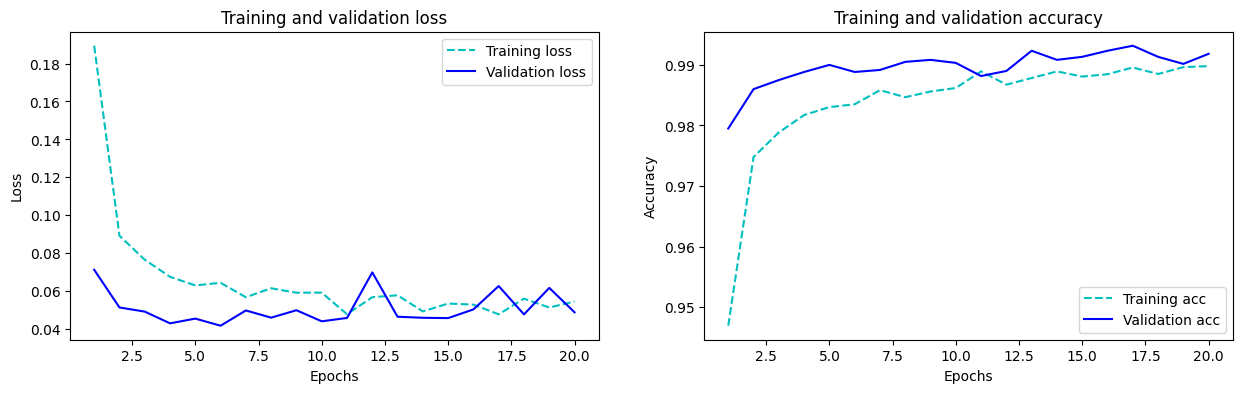

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr20.h5')
show_result(history)

```verbose=False``` will show you nothing (silent)

```verbose=TURE``` will show you an animated progress bar like this:
[==============================]


Last train accuracy: 0.9936666488647461
Last validation accuracy: 0.9921666383743286


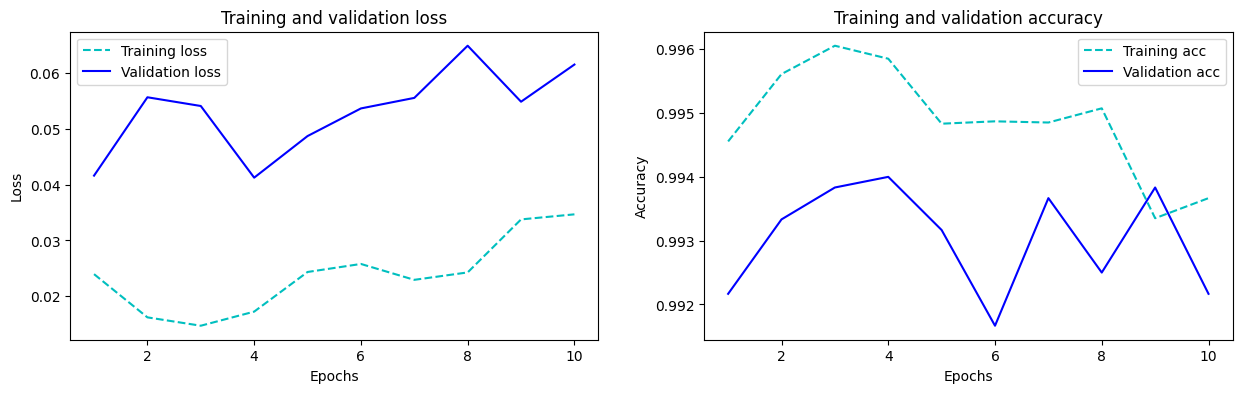

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=False)
cnn.save('baseline_model_itr10_verboseFalse.h5')
show_result(history)

Last train accuracy: 0.9959629774093628
Last validation accuracy: 0.9934999942779541


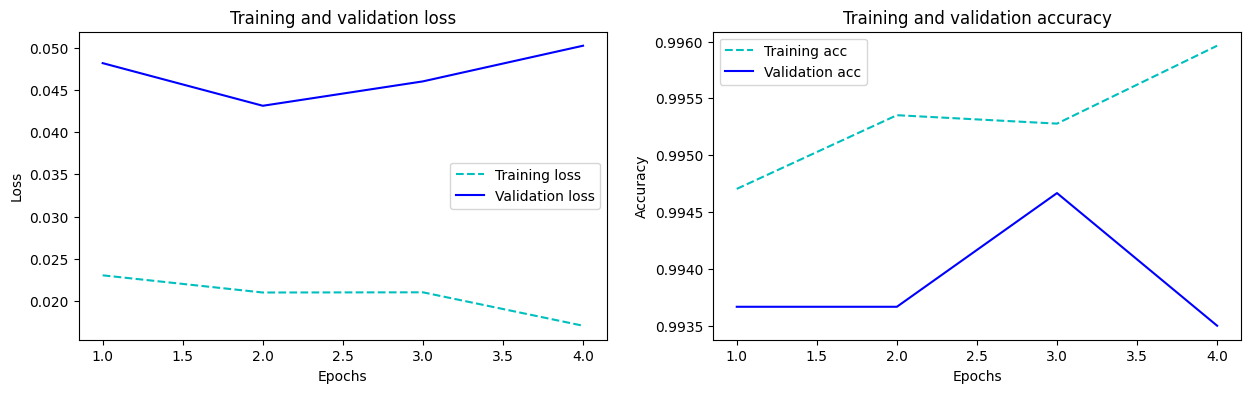

In [ ]:
cnn = models.load_model('baseline_model_itr20.h5')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stop],
                  verbose=False)
cnn.save('baseline_model_itr10_earlystop.h5')
show_result(history)

### 5. Evaluate your model
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [ ]:
pred_class = evaluation_report(cnn,X_test,y_test)

313/313 [==============================] - 13s 40ms/step
[[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1129    1    1    0    0    0    4    0    0]
 [   0    0 1027    0    0    0    0    5    0    0]
 [   0    0    0 1008    0    1    0    1    0    0]
 [   0    0    1    0  976    0    1    0    1    3]
 [   0    0    0    6    0  884    1    0    0    1]
 [   2    3    0    1    2    1  948    0    1    0]
 [   0    0    1    0    0    0    0 1025    1    1]
 [   1    0    2    1    0    0    1    2  963    4]
 [   0    0    0    0    4    2    0    1    0 1002]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99

### 5.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(61, 28, 28)


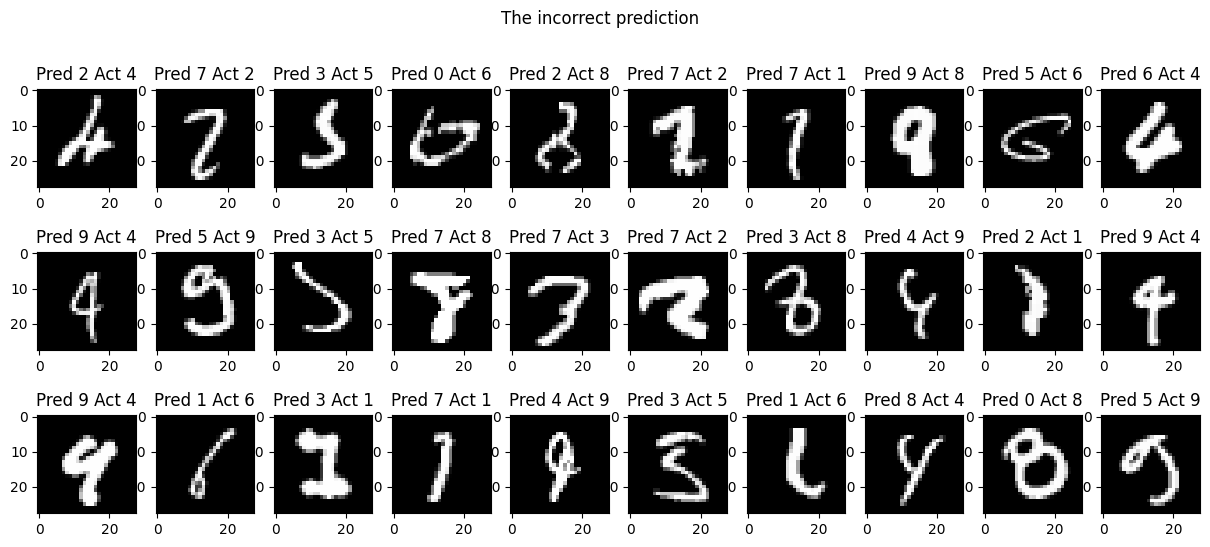

In [ ]:
show_false_prediction(pred_class, X_test, y_test)

**Discuss the results**

ฟังก์ชัน show_false_prediction สร้างมาเพื่อแสดงภาพในกรณี model prediction ไม่ถูกต้อง โดยฟังก์ชันจะผ่านการ prediction แต่ละครั้งและตรวจสอบว่าตรงกับ label จริงหรือไม่ หากการ prediction ไม่ตรงกับ label จริง จะถือว่าเป็นการ prediction ไม่ถูกต้อง และแสดงรูปภาพที่เกี่ยวข้องพร้อมกับค่า predicted และ actual label ซึ่งการ prediction ที่ผิดพลาดเกิดขึ้นได้หลายแบบ เช่น

**Problem**: เมื่อดูที่ predicted และ actual label  จะสามารถระบุรูปแบบข้อผิดพลาดทั่วไปได้ เช่น model อาจทำให้ตัวเลขบางหลักผิดพลาด เช่น 3 และ 5 เนื่องจากความคล้ายคลึงกันทางการมองเห็น

**ข้อจำกัดของโมเดล**: อาจเกิดจากข้อจำกัดของ model ที่มี dataset ไม่เพียงพอ ต้องมีการเพิ่มข้อมูลที่มีหลายลักษณะมากขึ้นเพื่อมาใช้ในการ train data และเตรียมข้อมูลเพิ่มสำหรับการ test data เพิ่มเติมสำหรับกรณีเฉพาะ หรือการปรับ model architecture

**Data Quality**: การเขียนตัวเลขที่ไม่ชัดเจนพอแม้กระทั่งการมองด้วยสายตาที่การตีความตัวเลขของแต่ละคนยังแตกต่างกัน หากสังเกตเห็นว่ารูปภาพที่จัดประเภทผิดบางรูปมีความคลุมเครือหรือมี label ไม่ดี อาจบ่งบอกถึงปัญหาคุณภาพของข้อมูลที่ต้องแก้ไขใน dataset

**Fine-Tuning**: หากต้องการปรับปรุง model performance อาจจะทำการปรับ fine-tune ของ model เช่น อาจใช้การเพิ่มข้อมูลหรือปรับไฮเปอร์พารามิเตอร์ของ model เพื่อแก้ไขรูปแบบข้อผิดพลาดเฉพา

### 5.3 Data Augmentation

Using the ```ImageDataGenerator``` module to generate more data. This technique is called data augmentation. It help generate more variation of the data which help prevent overfit and generalize better.

Lookup in the Keras document to see what method does it provide. https://keras.io/preprocessing/image

Becasue we want to build a data generator object, we have to re-load the data and specify rescale argument in ImageDataGenerator module.

In [ ]:
# Re-load the image data
(X_train,y_train), (X_test,y_test) = mnist.load_data()

# Because the ImageDataGenerator require tensor of 4 dimension
# Reshape data to 4 dimension (batch, width, height, channel)
def reshape_gray(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    return data

X_train = reshape_gray(X_train)
X_test = reshape_gray(X_test)

# split to validation set and train set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [ ]:
# update global variable
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

BATCH_SIZE = 32

In [ ]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Create an Iterator object.
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

<ipython-input-19-b5ddd7ff4781>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last train accuracy: 0.930981457233429
Last validation accuracy: 0.981333315372467


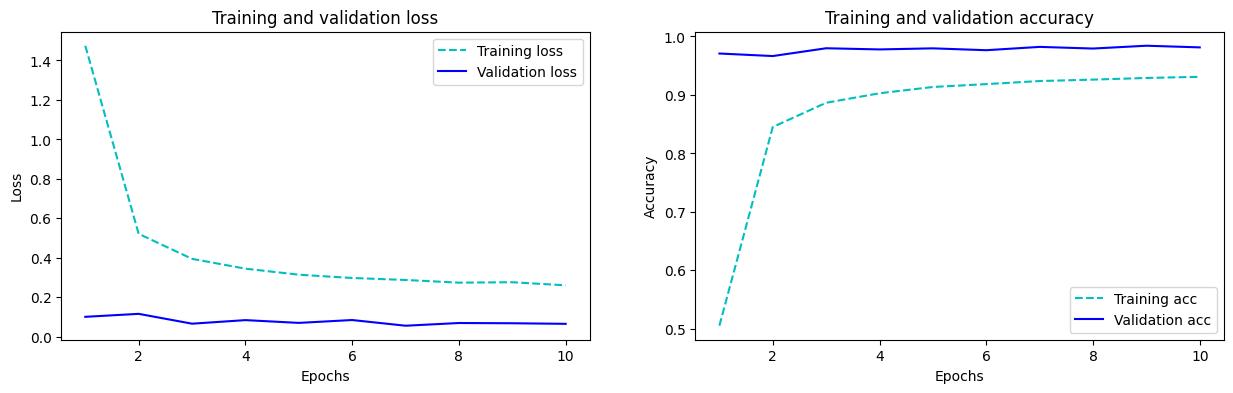

In [ ]:
# Using fit_generator to train your model. We don't need to specify the batch size since we already done that when we create Iterator
history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=None,
                              validation_data=validate_generator,
                              workers=8, use_multiprocessing=True)
cnn.save('baseline_model_itr10_data_aug.h5')
show_result(history)

<ipython-input-20-e3f4e210fb98>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,


Last train accuracy: 0.9376296401023865
Last validation accuracy: 0.984000027179718


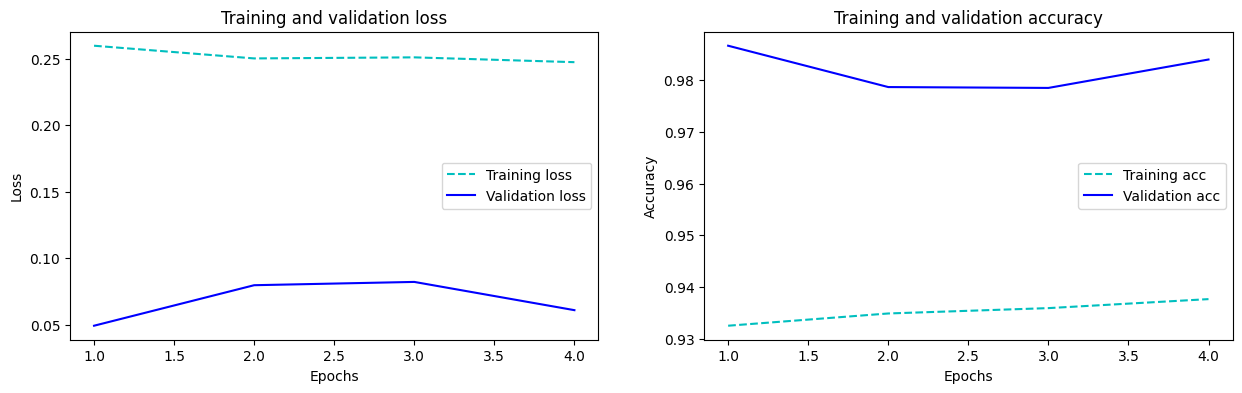

In [ ]:
# Add early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Load previous model
cnn = models.load_model('baseline_model_itr10_data_aug.h5')


history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=[early_stop],
                              validation_data=validate_generator)

cnn.save('baseline_model_itr10_data_aug_earlystop.h5')
show_result(history)

In [ ]:
# Let it run
history = cnn.fit_generator(train_generator,
                              epochs=100,
                              verbose=0,
                              validation_data=validate_generator)

cnn.save('baseline_model_itr100_data_aug.h5')
show_result(history)

<ipython-input-21-2657db9c7e7c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,



**5.5 Compare the result**

Compare the result between a model with data augmentation and without data augmentation

ANS : ประสิทธิภาพของ โมเดล ที่ fit ด้วย data ที่ได้ไปลองหมุนมามีประสิทธิภาพดีกว่า
1. จากกราฟ data ที่ยังไม่ได้หมุนนั้น แม้จะมีบ้างที่ validation set performดีกว่า train set แต่ก็ไม่ได้ชัดเจนขนาดนั้น ยังมีในบางโอกาสทีแย่กว่า และส่วนมากมักจะเป็นดังนั้น ในขณะที่ data ที่ผ่านการหมุน หรือ augmented data นั้น ทำให้ model ที่ fit มี validation set ที่ perform ได้ดีกว่า train set อยู่เสมอ
2. คาดว่าการที่นำ data ไปหมุนก่อนนำมา train จะเป็นการสอนให้ model รู้จัก data ในแต่ละมุมมองมากขึ้น ทำให้รับมือกับรปที่ไม่เคยเห็นมาก่อนได้ดีกว่า จึงทำให้ผลของ validation set ออกมาดี คือ มีค่า loss ที่น้อยกว่า และมีค่า accuracy ที่มากกว่า test set อยู่ในทุกๆ iteration

### 6. Visualize Layer Activation
**Note:** the function is defined above.

In [ ]:
# Create an activation model (the model with convolution layer only)

num_conv = 4# Number of convolutional layer in your model (if more than 4, just used 4)
layer_outputs = [layer.output for layer in cnn.layers[:num_conv]]
activation_model = models.Model(inputs=cnn.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
from keras.preprocessing import image

# load image to feed into network
img = image.load_img('/content/test_data_1.png',target_size=(28,28),grayscale=True)
img_tensor = image.img_to_array(img)

# Preprocess data
img_tensor = np.expand_dims(image.img_to_array(img),axis=0)/255.

# Feed into activation model to get an activation value
activation = activation_model.predict(img_tensor)

In [ ]:
### Feed your activation, model and number of layer you want to see
show_layer_activation(activation,activation_model,num_layer=4)

**What do you think the network can detect?**

จากภาพที่พล็อต label ที่แสดงคือของ conv_1, conv_2, max_pool_1, และ conv_3
- conv_1_input: network นี้จะทำการแสดง input layers ก่อน ในกรณีนี้พารามิเตอร์ input_shape ใน Convolutional Layer แรก (conv_1) จะบอก network ถึงรูปร่างที่คาดหวังของ input data ซึ่งในกรณีคือ (28, 28, 1) โดยระบุภาพระดับสีเทาที่มีขนาด 28x28 พิกเซลและ 1 channel

- First Convolutional Layer (conv_1): layer นี้จะบันทึก low-level features  เช่น edges, corners, และ simple textures ใน input imageโดยจะ detect รูปร่างพื้นฐานและการไล่ระดับสี ในการแสดงภาพ จะเห็นรูปแบบที่สอดคล้องกับ simple features

- Second Convolutional Layer (conv_2): layer นี้จะบันทึก low-level features คล้าย layer conv_1 แต่สามารถระบุ features ที่ซับซ้อนได้มากกว่า conv_1 เช่น texture ที่จะเห็นว่าแตกต่างจาก conv_1 ซึ่งการแสดงภาพอาจแสดงรูปแบบที่เป็น abstract pattern มากขึ้น

- max_pool_1 จะตามหลัง Convolutional Layer สองชั้น (conv_1 และ conv_2) ซึ่งจะลดขนาดตัวอย่างส่งผลให้เกิด feature maps ที่เล็กลงทั้งในด้านความสูงและความกว้าง แต่ยังคง features หลักไว้ ซึ่งจะถูกส่งต่อไปยัง layer ถัดไปเพื่อการ processing และ abstraction เพิ่มเติม

- Deeper Convolutional Layers (conv_3): ใน layer นี้รูปภาพจะดู abstract pattern มากขึ้นและดูมีนัยสำคัญมากขึ้นโดยจะแสดง ส่วนที่ซับซ้อนของ object, object boundaries, หรือแสดงส่วนทั้งหมดของ object โดย layer นี้มีหน้าที่ทำความเข้าใจ input data

### 7. Transfer Learning
- What is transfer learning https://towardsdatascience.com/transfer-learning-946518f95666
- which transfer learning method to use https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

The following is a tutorial code to load and freeze some layer. Keras also come with a build-in pre-train network on imageNet dataset (See www.image-net.org)

Keras Pre-train Network https://keras.io/applications

#### 7.1.1 Use Build-in Pre-train Network
Keras come with a build-in pre-train network that let you download and use it in your problem. You can import only model structure or import neuron weight that had been train on imageNet.

In [ ]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150,150,3))

In [ ]:
vgg.summary()

#### 7.1.2 Use Our Pre-train Network

When we are doing the deep learning/machine learning project, sometime, we may encounter a similar problem. After several project, we will have many existing model that we experiment and develop. We can used these model as a pre-train network to solve a new problem. This can save a hugh cost (time and money) and jump start our new project very quickly.

In [ ]:
prev_cnn = models.load_model('baseline_model_itr20.h5')
prev_cnn.summary()

In [ ]:
# Use .pop() to remove the last layer
# In this case, we want to remove last two layer

prev_cnn.pop()
prev_cnn.pop()

In [ ]:
# See how our model change
prev_cnn.summary()

For both method, if you want to change input size of your network, you have to create a model using functional API.
See https://keras.io/models/model

#### 7.2.1 Freezing layer - All

In [ ]:
# If we don't want to train these layer, we have to freeze these layer.
# Note that if we want a pre-train as a weight initializer, we don't have to freeze the layer.

prev_cnn.trainable = False

#### 7.2.2 Freezing layer - Specific layer

In [ ]:
# Freeze a specific layers
# Freeze first 3 layer
for i in range(3):
    prev_cnn.layers[i].trainable = False

#### 7.3 Connnect your model

In [ ]:
# Time to create a new model
new_cnn = models.Sequential()

# Add convolutional layer as a pre-train network
new_cnn.add(prev_cnn)

# Define fully-connect layer
new_cnn.add(layers.Dense(256,activation='elu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(10,activation='softmax',name='output'))

# Show how your network looklike
new_cnn.summary()

After this process, you can use your network as the way you like.